In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Found 2565 files belonging to 36 classes.
Using 2052 files for training.
Found 2565 files belonging to 36 classes.
Using 513 files for validation.
Found classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_10 (Lambda)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 36)                  │          46,116 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,304,100 (8.79 MB)

 Trainable params: 46,116 (180.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.1793 - loss: 3.1710 - val_accuracy: 0.7407 - val_loss: 1.3640
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7189 - loss: 1.2619 - val_accuracy: 0.8382 - val_loss: 0.8327
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8463 - loss: 0.7414 - val_accuracy: 0.8830 - val_loss: 0.5878
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9048 - loss: 0.5052 - val_accuracy: 0.8830 - val_loss: 0.4910
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9255 - loss: 0.4202 - val_accuracy: 0.9201 - val_loss: 0.3897
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9398 - loss: 0.3355 - val_accuracy: 0.9396 - val_loss: 0.3316
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9466 - loss: 0.2776 - val_accuracy: 0.9376 - val_loss: 0.3036
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9592 - loss: 0.2418 - val_accuracy: 0.9298 -

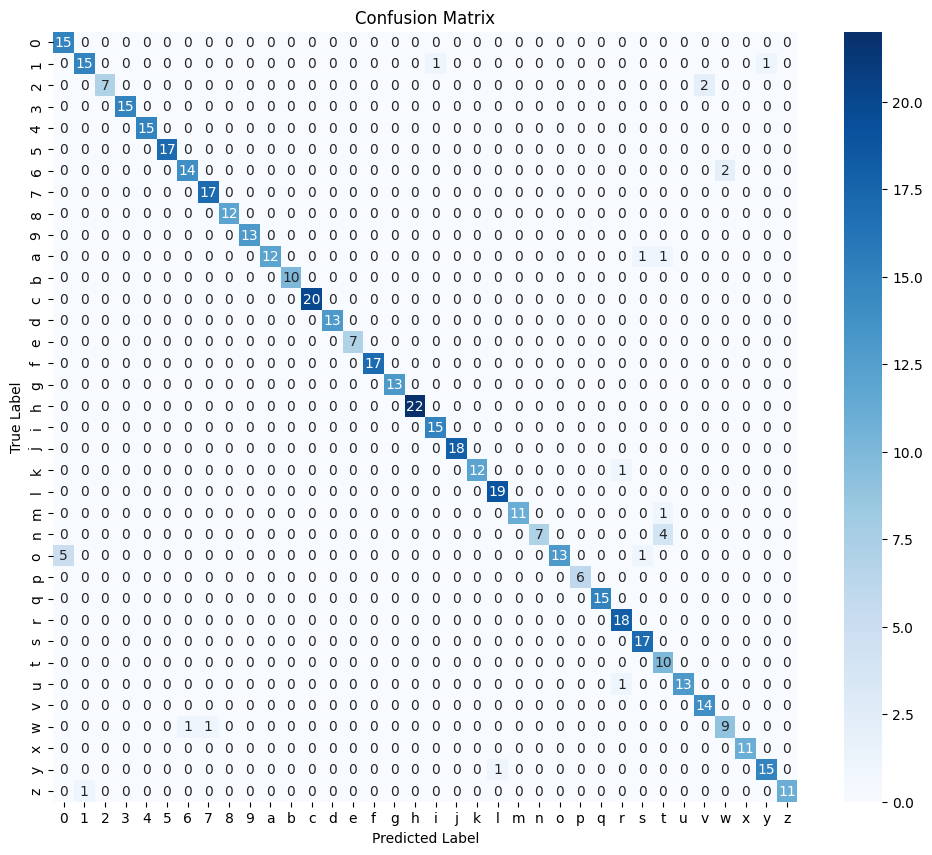

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


data_dir = '/content/drive/MyDrive/asl_dataset'

# Parameters
IMG_SIZE = 224    # MobileNetV2 uses 224x224 images
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Retrieve and check class names.
class_names = train_ds.class_names
print("Found classes:", class_names)
if len(class_names) != 36:
    raise ValueError(f"Expected 36 classes, but found {len(class_names)}. Check your folder structure.")

# Optimize dataset performance.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load MobileNetV2 without the top classification layers.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the base model

# Build the full model.
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Lambda(lambda x: (x / 127.5) - 1.0)(inputs)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(36, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# Compile the model.
model.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print model summary.
model.summary()

# Train the model.
EPOCHS = 10  # Adjust the number of epochs as needed
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix.
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix.
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


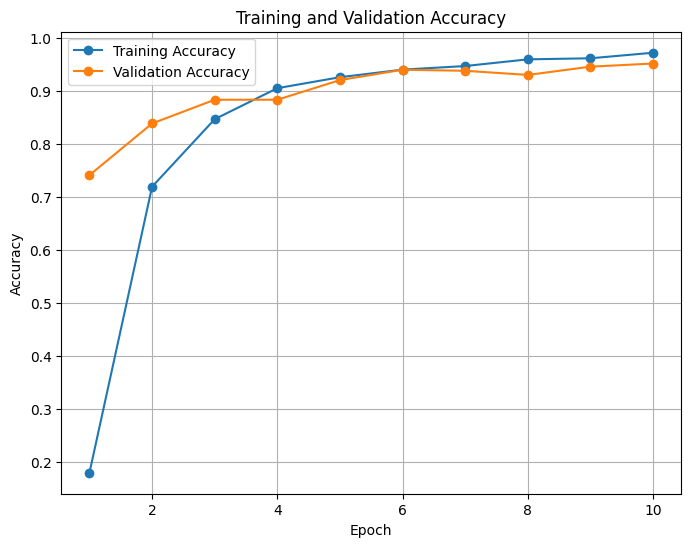

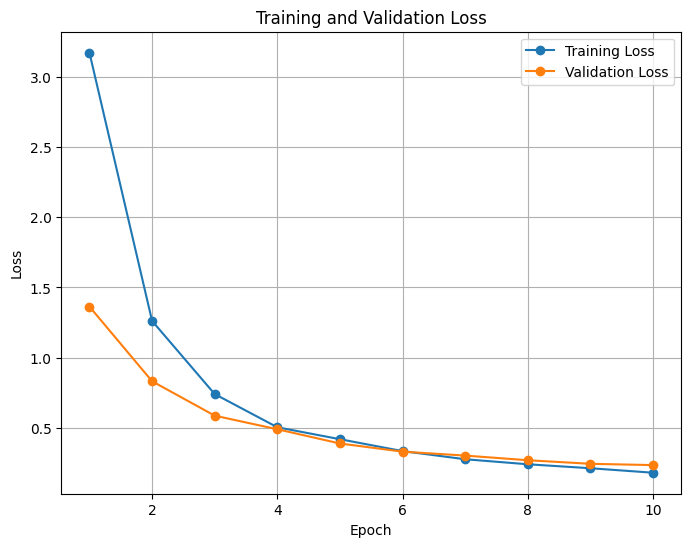

In [2]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_acc = [0.1793, 0.7189, 0.8463, 0.9048, 0.9255, 0.9398, 0.9466, 0.9592, 0.9612, 0.9717]
train_loss = [3.1710, 1.2619, 0.7414, 0.5052, 0.4202, 0.3355, 0.2776, 0.2418, 0.2136, 0.1817]

val_acc = [0.7407, 0.8382, 0.8830, 0.8830, 0.9201, 0.9396, 0.9376, 0.9298, 0.9454, 0.9513]
val_loss = [1.3640, 0.8327, 0.5878, 0.4910, 0.3897, 0.3316, 0.3036, 0.2706, 0.2452, 0.2359]


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc,   'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss,   'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf

# Convert the Keras model to TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

tflite_model_path = '/content/drive/MyDrive/my_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")


Saved artifact at '/tmp/tmps48axr4c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_2425')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  136314791469776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438976528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438966928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136314770293776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136314770293008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438976144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438973840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438974992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438977680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136313438966160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13631343